# Bibliotécas

In [1]:
import inflection
import s3fs
import sqlite3
import pickle
import re
import os
import warnings
import umap.umap_                                 as umap
import pandas                                     as pd
import numpy                                      as np
import seaborn                                    as sns
from statsmodels             import api           as sm
from matplotlib              import pyplot        as plt
from sklearn                 import preprocessing as pp
from sklearn                 import mixture       as mx
from sklearn                 import ensemble      as en
from sklearn                 import cluster       as c
from sklearn                 import metrics       as m
from sklearn                 import decomposition as dd
from plotly                  import express       as px
from scipy.cluster           import hierarchy     as hcy
from matplotlib              import cm
from sqlalchemy              import create_engine
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold        import TSNE
from matplotlib.gridspec     import GridSpec

In [2]:
# Variáveis para acessar o S3 da AWS
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

# Funções

In [3]:
def renomear_colunas(df):
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.2 Carregar os dados

In [4]:
ls -la ../dataset

total 41820
drwxr-xr-x  2 leonardo leonardo     4096 Jan 23 21:46 ./
drwxr-xr-x 11 leonardo leonardo     4096 Jan 27 01:29 ../
-rw-r--r--  1 leonardo leonardo 42697197 Apr 29  2021 ecommerce.csv
-rw-r--r--  1 leonardo leonardo   114166 Jan 25 15:13 embedding_tree.csv


In [5]:
# Carregando os dados direto do S3 da AWS
#pip install s3fs
path_aws = 's3://cluster-insiders-dataset' # Caminho absoluto para posteriormente
df_raw = pd.read_csv(path_aws + '/ecommerce.csv', encoding = 'latin1')

# Carregando os dados localmente
#path_local = '/home/leonardo/projetos_/programa_de_fidelidade/dataset' # Caminho absoluto para posteriormente
# utilizar o PaperMill (Executador de jupyter notebook)
#df_raw = pd.read_csv(path_local + '/ecommerce.csv', encoding = 'latin1')
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis = 1)

df1 = df_raw.copy()

### 1.3 Dimensão dos dados

In [6]:
df1.shape

(541909, 8)

### 1.4 Editar as colunas

In [7]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
df1 = renomear_colunas(df1)

In [9]:
#Corrigindo o nome da coluna 'customer_id' 
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 
               'invoice_date', 'unit_price', 'customer_id', 'country']

### 1.5 Tipo de dados

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

#### 1.5.1 Editar os tipos de dados

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### 1.6 Verificar NA's

In [13]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

#### 1.6.1 Tratar NA's

In [14]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [15]:
# Para preencher a coluna 'customer_id' faltantes, optou-se em pegar o maior nº do 'customer_id', neste 
# caso 18287 e implementar o novo 'customer_id' a partir do nº 19000, então para cada conjunto 'invoice_no'
df_not_missing['customer_id'].max()

18287.0

In [16]:
# Criando a referência
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# Juntando o dataframe original com o dataframe de referência
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# Juntando os dados diferentes de NA das colunas 'customer_id_x' e 'customer_id_y' na coluna 'customer_id' original
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
# combine_first
# Essa função combina os valores de 'customer_id_x' e 'customer_id_y', priorizando 'customer_id_x'
# sempre que estiver disponível e preenchendo com 'customer_id_y' quando 'customer_id_x' é nulo.

# Retirando as colunas 'customer_id_x' e 'customer_id_y'
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y']) 

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850.0


#### 1.6.2 Verificar NA's novamente

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.7 Descrição estatística do negócio

#### 1.7.1 Separar as colunas em variáveis numéricas e variáveis categóricas

In [18]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

#### 1.7.2 Atributos numéricos

In [19]:
#Métricas de tendência central: média e mediana
central_1 = pd.DataFrame(num_attributes.apply(np.mean)).T
central_2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Métricas de dispersão: desvio padrão, mínimo, máximo, aplitude, assimetrica e curtose
dispersao_1 = pd.DataFrame(num_attributes.apply(np.std)).T
dispersao_2 = pd.DataFrame(num_attributes.apply(np.min)).T
dispersao_3 = pd.DataFrame(num_attributes.apply(np.max)).T
dispersao_4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dispersao_5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dispersao_6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

metricas = pd.concat([dispersao_2, dispersao_3, dispersao_4, central_1, central_2, dispersao_1, dispersao_5, dispersao_6]).T
metricas.columns = ['min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetria', 'kurtosis']
metricas

,min,max,amplitude,mean,median,std,assimetria,kurtosis
quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.3 Atributos categóricos

In [20]:
# invoice_no (encontrado invoice com letras e números)
#cat_attributes['invoice_no'] = cat_attributes['invoice_no'].astype(int)
df_letter_invoices = (df1.loc[df1['invoice_no']
                         .apply(lambda x: bool(re.search('[^0-9]+', x))), :])

print('Total de invoices com letras e números: {}'.format(len(df_letter_invoices)))
print('Total de quantidades negativas: {}'.format(len(df_letter_invoices['quantity'] < 0 )))

Total de invoices com letras e números: 9291
Total de quantidades negativas: 9291


In [21]:
# stock_code
len(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

1124

In [22]:
# stock_code
# Identificando as strings com somente letras
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
# Remover os itens ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], pois parece ser sujeira nos dados

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [23]:
# customer_id
# Remover o customer_id = 16446.0 pois é um outlier e não tem sentido com o problema estudado
df1 = df1[~df1['customer_id'].isin([16446.0])]

# 2. (Limpeza dos dados) Passo 2: Filtragem de variáveis (restrição do negócio)

In [24]:
df2 = df1.copy()

### 2.1 Atributos numéricos

In [25]:
df2.shape

(541905, 8)

In [26]:
# unit_price > 0.04
df2 = df2.loc[df2['unit_price'] > 0.04, :]

### 2.2 Atributos categóricos

In [27]:
# stock_code > 0.0
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M',
                                   'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis = 1)

# country
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

In [28]:
# quantity - Separando as quantidades positivas e negativas
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# 3. (Limpeza dos dados) Passo 3: Engenharia de variáveis

In [29]:
df3 = df2.copy()

### 3.1 Derivando as variáveis a partir das variáveis originais

#### 3.1.1 Criação da coluna de referência

In [30]:
# Criando uma tabela de referência
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity',
                   'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)
df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


#### 3.1.2 Criação da coluna Monetary

In [31]:
# Faturamento (qtde * preço), também chamada como Gross_Revenue
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

/tmp/ipykernel_13505/1183862866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Criação da coluna Recency

In [32]:
# Recência (qtde dias até a última compra do cliente, ou seja, maior data do dataset - data última compra)
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.5 Criação da coluna Quantidade de produtos comprados <font color = 'red'>(Task definidas no começo do projeto)</font>

In [33]:
# Quantidade de produtos comprados
df_qtde = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns = {'stock_code': 'qty_products'}))

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_qtde, on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
dtype: int64

#### 3.1.8 Criação da coluna Frequency

In [34]:
# Frequência
df_freq = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby('customer_id')
                                                                      .agg(max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                           buy_ = ('invoice_no', 'count')).reset_index())

df_freq['frequency'] = df_freq[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_freq[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
frequency        91
dtype: int64

#### 3.2.0 Criação da coluna Número de returns <font color = 'red'>(Task definidas no começo do projeto)</font>

In [35]:
# Número de returns
df_returns = (df2_returns[['customer_id','quantity']].groupby('customer_id')
                                                     .sum()
                                                     .reset_index()
                                                     .rename(columns = {'quantity': 'qty_returns'}))

# Convertendo para positivo
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

# Juntando os colunas criadas a coluna de referência
df_ref = pd.merge(df_ref, df_returns, on = 'customer_id', how = 'left')

# Se encontrar linhas com NA's substituir por 0
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

# Após fazer qualquer junção de dataframes, verificar se existem NA's,
# pois é uma maneira de verificar se deu certo a junção
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_products     91
frequency        91
qty_returns       0
dtype: int64

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados (Negócio)

In [36]:
df4 = df_ref.dropna()

### 4.3 Estudo do espaço (Algoritmos de Embedding)

In [37]:
#df43 = df4.drop(columns = 'customer_id', axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']
df43 = df4[cols_selected].drop(columns = 'customer_id', axis = 1)

In [38]:
df43.head()

,gross_revenue,recency_days,qty_products,frequency,qty_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


In [39]:
mm = pp.MinMaxScaler()
fs = s3fs.S3FileSystem(anon = False, key = AWS_ACCESS_KEY_ID, secret = AWS_SECRET_ACCESS_KEY)

# Baixando as transformações que foram salvas em arquivo pickle na máquina local
#gross_revenue_scaler = pickle.load(open('../transformacoes/gross_revenue_scaler.pkl', 'rb'))
#df43['gross_revenue'] = gross_revenue_scaler.transform(df43[['gross_revenue']])

#recency_days_scaler = pickle.load(open('../transformacoes/recency_days_scaler.pkl', 'rb'))
#df43['recency_days'] = recency_days_scaler.transform(df43[['recency_days']])

#qty_products_scaler = pickle.load(open('../transformacoes/qty_products_scaler.pkl', 'rb'))
#df43['qty_products'] = qty_products_scaler.transform(df43[['qty_products']])

#frequency_scaler = pickle.load(open('../transformacoes/frequency_scaler.pkl', 'rb'))
#df43['frequency'] = frequency_scaler.transform(df43[['frequency']])

#qty_returns_scaler = pickle.load(open('../transformacoes/qty_returns_scaler.pkl', 'rb'))
#df43['qty_returns'] = qty_returns_scaler.transform(df43[['qty_returns']])

# Baixando as transformações que foram salvas em arquivo pickle na máquina virtual (S3 da AWS)
gross_revenue_scaler = pickle.load(fs.open('s3://cluster-insiders-dataset/gross_revenue_scaler.pkl', 'rb'))
df43['gross_revenue'] = gross_revenue_scaler.transform(df43[['gross_revenue']])

recency_days_scaler = pickle.load(fs.open('s3://cluster-insiders-dataset/recency_days_scaler.pkl', 'rb'))
df43['recency_days'] = recency_days_scaler.transform(df43[['recency_days']])

qty_products_scaler = pickle.load(fs.open('s3://cluster-insiders-dataset/qty_products_scaler.pkl', 'rb'))
df43['qty_products'] = qty_products_scaler.transform(df43[['qty_products']])

frequency_scaler = pickle.load(fs.open('s3://cluster-insiders-dataset/frequency_scaler.pkl', 'rb'))
df43['frequency'] = frequency_scaler.transform(df43[['frequency']])

qty_returns_scaler = pickle.load(fs.open('s3://cluster-insiders-dataset/qty_returns_scaler.pkl', 'rb'))
df43['qty_returns'] = qty_returns_scaler.transform(df43[['qty_returns']])

x = df43.copy()

#### 4.3.1 PCA (Análise de Componentes Principais)

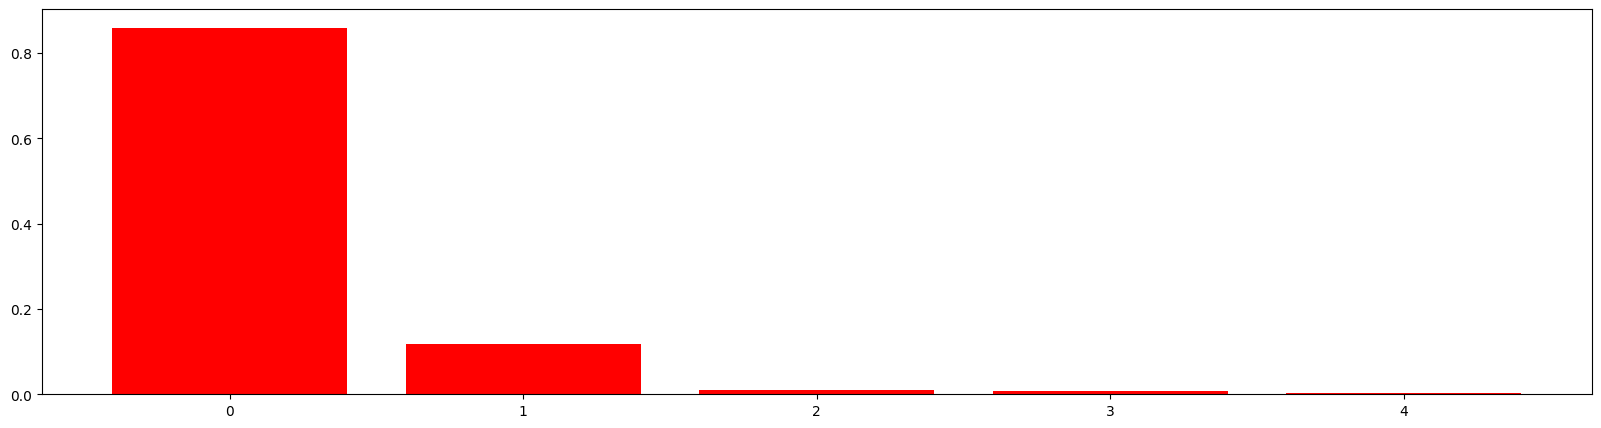

In [40]:
plt.figure(figsize = (20, 5))

pca = dd.PCA(n_components = x.shape[1]) # Qtde de colunas no dataframe

principal_components = pca.fit_transform(x)

# Plotando a variância dos componentes principais
variaveis = range(pca.n_components_) # Criando o eixo x

plt.bar(variaveis, pca.explained_variance_ratio_, color = 'red') # Criando o eixo y

# Criando um dataframe com as variáveis do PCA
df_pca = pd.DataFrame(principal_components);

In [41]:
df_pca.head()

,0,1,2,3,4
0,0.732391,-0.004850,-0.218847,0.906002,-0.024116
1,-0.164885,0.001723,0.013461,-0.019081,-0.002634
2,-0.309646,0.004853,0.022173,-0.007957,0.000900
3,-0.060174,-0.003282,-0.000790,-0.029390,0.004363
4,0.577148,-0.004218,0.016654,-0.055369,0.005157


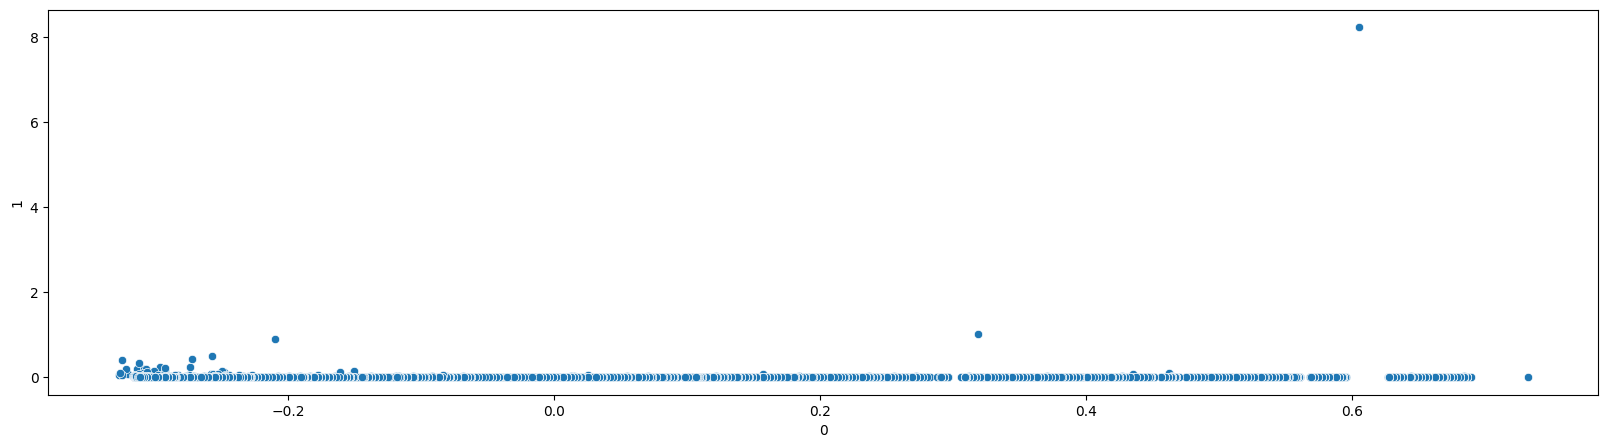

In [42]:
plt.figure(figsize = (20, 5))

sns.scatterplot(x = 0, y = 1, data = df_pca);

#### 4.3.2 UMAP (Uniform Manifold Approximation and Projection)

/home/leonardo/.pyenv/versions/3.8.0/envs/programa_de_fidelidade/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


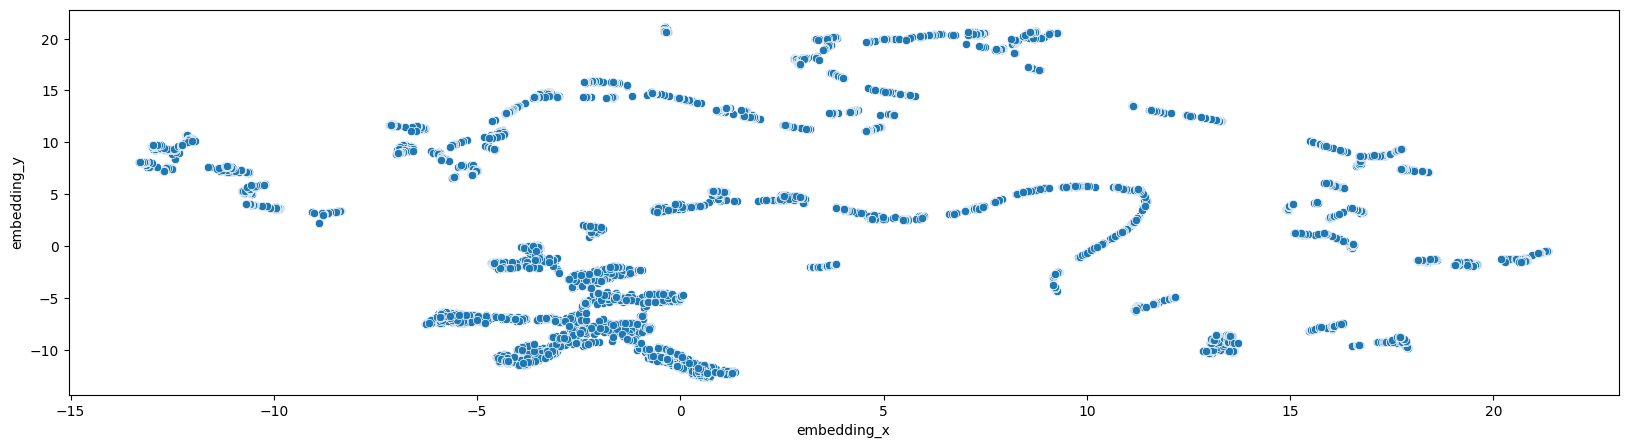

In [43]:
plt.figure(figsize = (20, 5))

reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(x)

#Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_umap);

#### 4.3.3 t-SNE (t-Distributed Stochastic Neighbor Embedding)

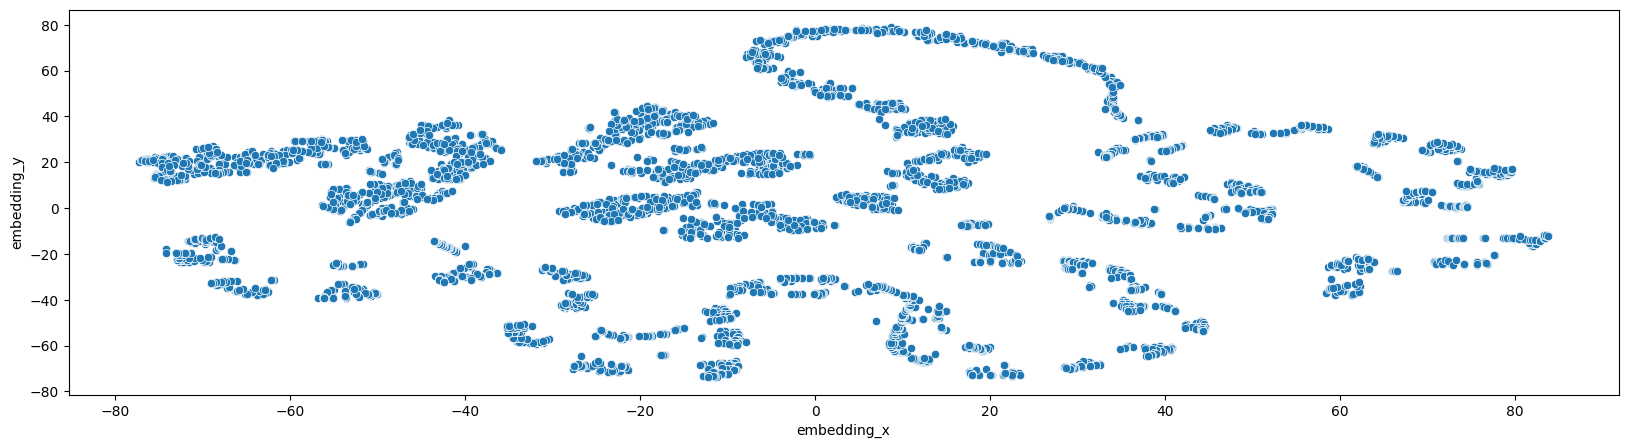

In [44]:
plt.figure(figsize = (20, 5))

reducer = TSNE(n_components = 2, random_state = 42) # n_components = 2 significa reduzir para 2d
embedding = reducer.fit_transform(x)

#Embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# Plotando o t_SNE
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tsne);

#### 4.3.4 Árvores

In [45]:
x = df43.drop(columns = 'gross_revenue', axis = 1)
y = df43['gross_revenue']

In [46]:
x.shape

(5695, 4)

In [47]:
ls -l ../modelo

total 28040
-rw-r--r-- 1 leonardo leonardo 27016110 Jan 27 00:54 rf_modelo.pkl
-rw-r--r-- 1 leonardo leonardo  1692789 Jan 27 00:54 umap_reducer.pkl


In [48]:
# Separando as variáveis em resposta e preditoras
x = df43.drop(columns = 'gross_revenue', axis = 1)
y = df43['gross_revenue']

# Definição do modelo
#rf_modelo = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
#rf_modelo.fit(x, y)

# Baixando as transformações que foram salvas em arquivo pickle
#rf_modelo = pickle.load(open('../modelo/rf_modelo.pkl', 'rb'))
# Baixando as transformações que foram salvas em arquivo pickle na máquina virtual (S3 da AWS)
rf_modelo = pickle.load(fs.open('s3://cluster-insiders-dataset/rf_modelo.pkl', 'rb'))

# Folhas
df_folhas = pd.DataFrame(rf_modelo.apply(x))

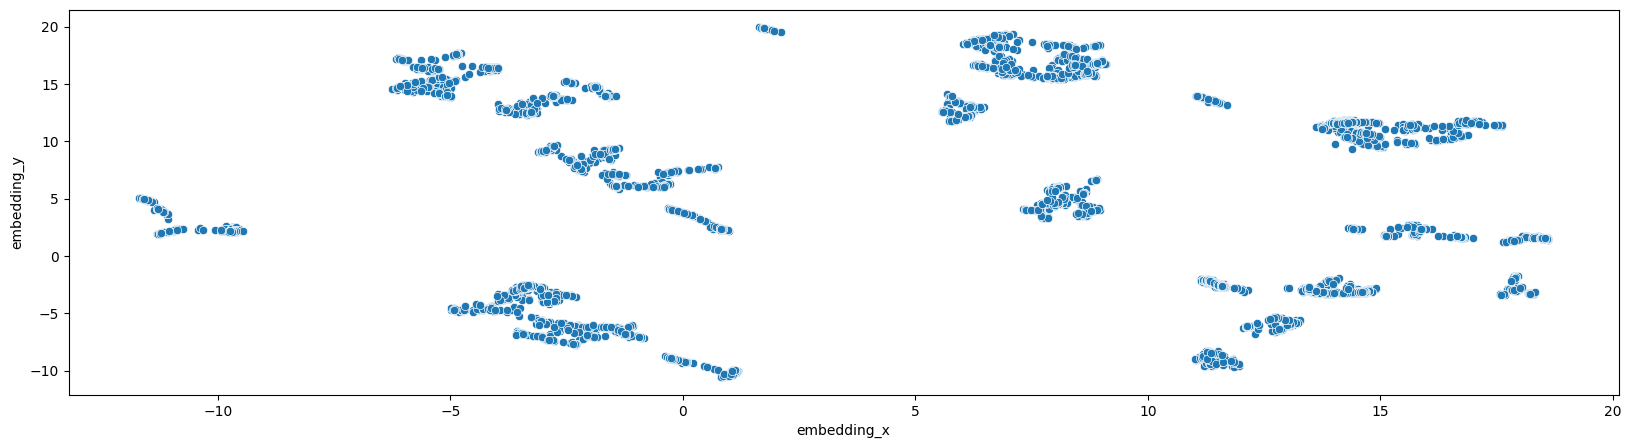

In [49]:
plt.figure(figsize = (20, 5))

# Aplicando um redutor de dimensionalidade
#reducer = umap.UMAP(random_state = 42)
#embedding = reducer.fit_transform(df_folhas)

# Baixando a redução que foi salva em arquivo pickle
#reducer = pickle.load(open('../modelo/umap_reducer.pkl', 'rb'))
# Baixando as transformações que foram salvas em arquivo pickle na máquina virtual (S3 da AWS)
reducer = pickle.load(fs.open('s3://cluster-insiders-dataset/umap_reducer.pkl', 'rb'))

embedding = reducer.transform(df_folhas)

#Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tree);

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [50]:
# Espaço das árvores
df5 = df_tree.copy()
df5.to_csv('../dataset/embedding_tree.csv', index = False) # Salvando arquivo CSV para manter fixo o espaço de embedding

# Espaço UMAP
#df5 = df_umap.copy()

# Espaço t-SNE
#df5 = df_tsne.copy()

# 7. (Algoritmos de Ml) Passo 7: Ajuste dos hiperparâmetros no algoritmo

In [51]:
#df7 = df6.drop(columns = ['customer_id'], axis = 1)
#x = df7.copy() #Está sendo utilizado o df_tree para verificar se os dados performam 
# melhor com os espaços de embedding
x = df5.copy()

In [52]:
clusters = np.arange(2, 25, 1)

### 7.1 Algoritmo K-means

In [53]:
kmeans_list = list()

for k in clusters:    
    # Definição do modelo
    kmeans = c.KMeans(n_clusters = k, n_init = 10, random_state = 42)
    
    # Treinamento do modelo
    kmeans.fit(x)
    
    # Predição do modelo
    labels = kmeans.predict(x)

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    kmeans_list.append(sil)

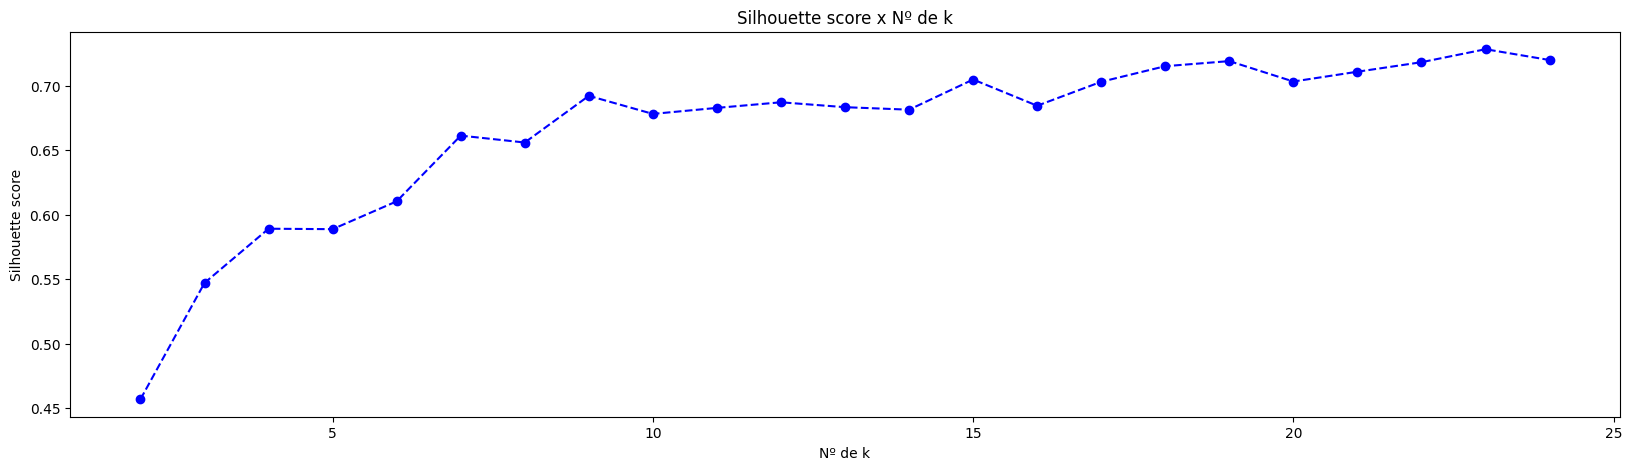

In [54]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

### 7.2 Algoritmo GMM (Modelo de Mezcla Gaussiana)

In [55]:
gmm_list = list()

for k in clusters:    
    # Definição do modelo
    gmm = mx.GaussianMixture(n_components = k, n_init = 10, random_state = 42)
    
    # Treinamento do modelo
    gmm.fit(x)
    
    # Predição do modelo
    labels = gmm.predict(x)

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    gmm_list.append(sil)

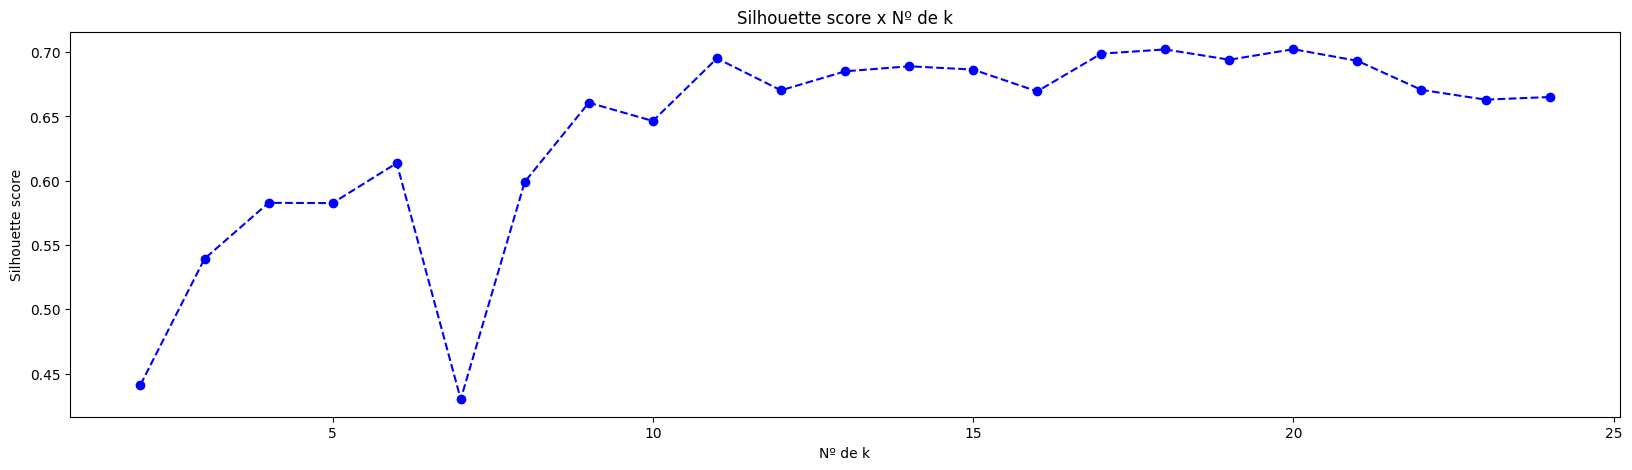

In [56]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

### 7.3 Algoritmo Hierárquico

In [57]:
hc_list = list()

for k in clusters:    
    # Definição e treinamento do modelo
    hc = hcy.linkage(x, 'ward')
    
    # Predição do modelo
    labels = hcy.fcluster(hc, k, criterion = 'maxclust')

    # Performance do modelo
    sil = m.silhouette_score(x, labels, metric = 'euclidean')
    hc_list.append(sil)

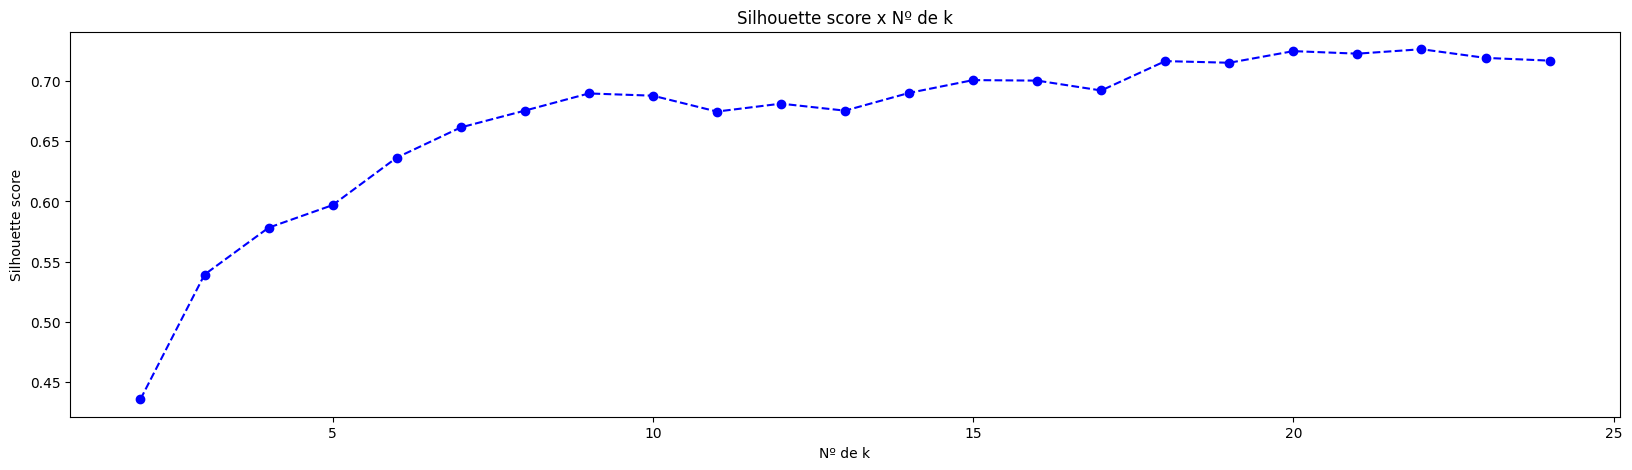

In [58]:
plt.figure(figsize = (20, 5))

plt.plot(clusters, hc_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('Nº de k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score x Nº de k');

### 7.5 Resultados dos Algoritmos

#### 7.5.1 Embedding Árvore

In [59]:
df_resultado_tree = pd.DataFrame({'Kmeans': kmeans_list,
                                  'GMM': gmm_list,
                                  'HC': hc_list}).T
df_resultado_tree.columns = clusters
df_resultado_tree.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.457036,0.547208,0.589220,0.588876,0.610452,0.661400,0.656050,0.692242,0.678229,0.682901,0.687243,0.683445,0.681508,0.704893,0.684568,0.703140,0.715235,0.719165,0.703340,0.710936,0.718316,0.728379,0.719994
GMM,0.441294,0.539319,0.582839,0.582644,0.613728,0.430053,0.599173,0.660753,0.646501,0.695205,0.670342,0.685144,0.689069,0.686521,0.669551,0.698879,0.702181,0.694172,0.702337,0.693316,0.670694,0.663127,0.665135
HC,0.435868,0.539319,0.578210,0.596979,0.636366,0.661434,0.675373,0.689639,0.687781,0.674609,0.681168,0.675355,0.690078,0.700713,0.700291,0.692100,0.716483,0.715112,0.724764,0.722660,0.726345,0.719146,0.716875


#### 7.5.2 Embedding UMAP

In [60]:
df_resultado_umap = pd.DataFrame({'Kmeans': kmeans_list,
                                  'GMM': gmm_list,
                                  'HC': hc_list}).T
df_resultado_umap.columns = clusters
df_resultado_umap.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.457036,0.547208,0.589220,0.588876,0.610452,0.661400,0.656050,0.692242,0.678229,0.682901,0.687243,0.683445,0.681508,0.704893,0.684568,0.703140,0.715235,0.719165,0.703340,0.710936,0.718316,0.728379,0.719994
GMM,0.441294,0.539319,0.582839,0.582644,0.613728,0.430053,0.599173,0.660753,0.646501,0.695205,0.670342,0.685144,0.689069,0.686521,0.669551,0.698879,0.702181,0.694172,0.702337,0.693316,0.670694,0.663127,0.665135
HC,0.435868,0.539319,0.578210,0.596979,0.636366,0.661434,0.675373,0.689639,0.687781,0.674609,0.681168,0.675355,0.690078,0.700713,0.700291,0.692100,0.716483,0.715112,0.724764,0.722660,0.726345,0.719146,0.716875


#### 7.5.2 Embedding t-SNE

In [61]:
df_resultado_tsne = pd.DataFrame({'Kmeans': kmeans_list,
                                  'GMM': gmm_list,
                                  'HC': hc_list}).T
df_resultado_tsne.columns = clusters
df_resultado_tsne.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Kmeans,0.457036,0.547208,0.589220,0.588876,0.610452,0.661400,0.656050,0.692242,0.678229,0.682901,0.687243,0.683445,0.681508,0.704893,0.684568,0.703140,0.715235,0.719165,0.703340,0.710936,0.718316,0.728379,0.719994
GMM,0.441294,0.539319,0.582839,0.582644,0.613728,0.430053,0.599173,0.660753,0.646501,0.695205,0.670342,0.685144,0.689069,0.686521,0.669551,0.698879,0.702181,0.694172,0.702337,0.693316,0.670694,0.663127,0.665135
HC,0.435868,0.539319,0.578210,0.596979,0.636366,0.661434,0.675373,0.689639,0.687781,0.674609,0.681168,0.675355,0.690078,0.700713,0.700291,0.692100,0.716483,0.715112,0.724764,0.722660,0.726345,0.719146,0.716875


# 8. (Algoritmos de Ml) Passo 8: Implementar os modelos de machine learning

### 8.2 Algoritmo GMM (Modelo de Mezcla Gaussiana)

In [62]:
k = 8

# Definição do modelo
gmm = mx.GaussianMixture(n_components = k, n_init = 10, random_state = 42)
    
# Treinamento do modelo
gmm.fit(x)
    
# Predição do modelo
labels = gmm.predict(x)

In [63]:
m.silhouette_score(x, labels, metric = 'euclidean')

0.59917295

# 9. (Algoritmos de Ml) Passo 9: Análise dos clusters

In [64]:
#df9 = df4.copy() #Está sendo utilizado o df_tree para verificar se os dados performam melhor com os espaços de embedding
#df9['cluster'] = labels
df9 = x.copy()
df9['cluster'] = labels

### 9.2 Perfil do cluster

In [65]:
# Para estornar as transformações dos dados, optou-se em pegar um
# dataset anterior as transformações, neste caso o dataset df4
df92 = df4.copy()
df92['cluster'] = labels

In [66]:
# Mudando os tipos dos dados para serem inseridos no banco de dados
df92['customer_id'] = df92['customer_id'].astype(int)
df92['recency_days'] = df92['recency_days'].astype(int)
df92['qty_products'] = df92['qty_products'].astype(int)
df92['qty_returns'] = df92['qty_returns'].astype(int)

In [67]:
df92.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372,297,17.000000,40,2
1,13047,3232.59,56,171,0.028302,35,2
2,12583,6705.38,2,232,0.040323,50,2
3,13748,948.25,95,28,0.017921,0,1
4,15100,876.00,333,3,0.073171,22,7


In [68]:
# Número de customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Média de faturamento
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on = 'cluster', how = 'inner')

# Média de dias de recência
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on = 'cluster', how = 'inner')

# Qtde de produtos
df_qty_products = df92[['qty_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_products, on = 'cluster', how = 'inner')

# Frequência
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, on = 'cluster', how = 'inner')

# Qtde de returns
df_qty_returns = df92[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty_returns, on = 'cluster', how = 'inner')

df_cluster.sort_values('gross_revenue', ascending = False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qty_products,frequency,qty_returns
2,2,949,16.663740,5806.268282,75.458377,338.325606,0.410979,155.404636
6,6,959,16.839333,2095.543764,77.867570,107.870699,0.252617,12.351408
3,3,804,14.117647,1640.181318,100.119403,63.769900,0.416387,10.691542
5,5,560,9.833187,739.996714,113.680357,37.132143,0.476815,3.785714
4,4,220,3.863038,680.796000,49.990909,11.713636,0.026261,7.968182
1,1,294,5.162423,654.440850,116.676871,27.387755,0.528373,13.819728
0,0,435,7.638279,443.548345,152.305747,20.455172,0.592647,1.586207
7,7,1474,25.882353,214.593677,179.043419,7.621438,0.993110,1.035957


#### Nº do cluster | Nome do cluster
##### 7 cluster Insiders
##### 4 cluster More products
##### 1 cluster Spend money
##### 5 cluster even more products
##### 0 cluster Less days
##### 6 cluster Less 1k
##### 3 cluster Stop returners
##### 2 cluster More buy

### 9.3 Reporte para entregar para o time de negócio

### Cluster 01: (Candidato à Insider)
    - Número de clientes: 783 (13,7% da base)
    - Receita média: 6.276,5
    - Recência em média: 11 dias
    - Média de produtos comprados: 242 produtos
    - Frequência de produtos comprados por dia: 0,04

#### Cluster 02:
    - Número de clientes: 648 (11,4% da base)
    - Receita média: 1.774,9
    - Recência em média: 31 dias
    - Média de produtos comprados: 102 produtos
    - Frequência de produtos comprados por dia: 0,03

#### Cluster 03:
    - Número de clientes: 1087 (18,5% da base)
    - Receita média: 1.424,4
    - Recência em média: 59,1 dias
    - Média de produtos comprados: 99 produtos
    - Frequência de produtos comprados por dia: 0,49

# 11. (Modelo em produção) Passo 10: Modelo em produção

### 11.1 Inserir no Banco de dados (Sqlite)

In [69]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qty_products       int64
frequency        float64
qty_returns        int64
cluster            int64
dtype: object

In [70]:
#import os
#import sqlite3
#import pandas as pd
#from sqlalchemy import create_engine

# Nome do arquivo do banco de dados
#db_filename = 'insiders_db_sqlite'

# Verificar se o arquivo existe e, se existir, removê-lo
#if os.path.exists(db_filename):
#    os.remove(db_filename)

# Conectar com o banco de dados e criar a tabela
#conn = sqlite3.connect(db_filename)
#cursor = conn.cursor()

# Remover a tabela se ela existir
#query_drop_table_insiders = "DROP TABLE IF EXISTS insiders"
#cursor.execute(query_drop_table_insiders)

# Commit para confirmar as alterações
#conn.commit()

# Executar a query de criação da tabela
#query_create_table_insiders = """
#    CREATE TABLE insiders (
#        customer_id     INTEGER,
#        gross_revenue   REAL,
#        recency_days    INTEGER,
#        qty_products    INTEGER,
#        frequency       REAL,
#        qty_returns     INTEGER,
#        cluster         INTEGER
#    )
#"""

#cursor.execute(query_create_table_insiders)

# Commit para confirmar as alterações
#conn.commit()

# Inserir os dados
#engine = create_engine('sqlite:///{}'.format(db_filename))

# Inserir os dados do DataFrame (df92) na tabela 'insiders'
#df92.to_sql('insiders', con = engine, if_exists = 'append', index = False)

In [71]:
# Consultando os dados no banco de dados
#query = """
#    SELECT * FROM insiders
#"""

# Utilizando o Pandas para executar a consulta e carregar os resultados em um DataFrame
#df = pd.read_sql_query(query, conn)

In [72]:
#df.head()

### 11.2 Inserir no Banco de dados (PostgreSQL)

In [73]:
#from sqlalchemy import create_engine

# Para conectar a um banco de dados
#host = 'programa-de-fidelizacao-insider.c3agyqiy035z.us-east-1.rds.amazonaws.com' # Seu host
#port = '5432' # Porta do banco de dados PostgreSQL
#database = 'postgres' # Seu banco de dados
#user = 'leonardo' # Seu usuário
#pwd = 'raposao01' # Sua senha

# Criando a URL explicitamente
#endpoint = f"postgresql://{user}:{pwd}@{host}:{port}/{database}"

# Criando a engine
#conn = create_engine(endpoint)

# Executar a query de criação da tabela
#query_create_table_insiders = """
#    CREATE TABLE IF NOT EXISTS insiders (
#        customer_id     INTEGER,
#        gross_revenue   REAL,
#        recency_days    INTEGER,
#        qty_products    INTEGER,
#        frequency       REAL,
#        qty_returns     INTEGER,
#        cluster         INTEGER
#    )
#"""
#conn.execute(query_create_table_insiders)

In [ ]:
from sqlalchemy import create_engine, text

# Configurações de conexão com o banco de dados PostgreSQL
host = 'banco-de-dados-insiders.c3agyqiy035z.us-east-1.rds.amazonaws.com'
port = '5432'
database = 'postgres'
user = 'leonardo'
pwd = 'raposao01'

# Criando a URL de conexão
endpoint = f"postgresql://{user}:{pwd}@{host}:{port}/{database}"

# Criando a engine
engine = create_engine(endpoint)

# Definindo o modelo da tabela
table_definition = """
    CREATE TABLE IF NOT EXISTS insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        qty_products    INTEGER,
        frequency       REAL,
        qty_returns     INTEGER,
        cluster         INTEGER
    )
"""

# Executando a query de criação da tabela
#with engine.connect() as connection:
#    connection.execute(text(table_definition))

# Fechando a conexão após terminar de usá-la
connection.close()

In [ ]:
# Inserir os dados do DataFrame (df92) na tabela 'insiders'
df92.to_sql('insiders', con = engine, if_exists = 'append', index = False)